In [1]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import utils

In [2]:
def imshow(inp, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,cmap='gray')
    plt.show()

In [3]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc * isize * isize),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize)

In [4]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [5]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

In [6]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [7]:
ngpu = 1 # number of GPUs to use
nz = 100 # size of the latent z vector
ngf = 512
ndf = 512
nc = 1 # input image channels
n_extra_layers = 0 # Number of extra layers on gen and disc

imageSize = 28
batchSize = 100
n_workers = 2


adam = False
lrD = 0.00005
lrG = 0.00005

beta1 = 0.5 # beta1 for adam. default=0.5
niter = 500 # number of epochs to train for
Diters = 5 #number of D iters per each G iter



clamp_lower = -0.01
clamp_upper = 0.01

experiment = './experiment' # Where to store samples and models
data_root = './data'

epsilon = 1 # panalty weight
L = 10 # sinkhorn iteration num

netG_path = experiment + '/WGANnetG.pth'
netD_path = experiment + '/WGANnetD.pth'

cuda = True

In [8]:
# get data
dataset = dset.MNIST(root=data_root, download=True,
                           transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=n_workers)

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [17]:
netG = MLP_G(imageSize, nz, nc, ngf, ngpu)
netD = MLP_D(imageSize, nz, nc, ndf, ngpu)

netG.apply(weights_init)
try: # load checkpoint if needed
    netG.load_state_dict(torch.load(netG_path))
    print("load parameters")
except:
    pass
print(netG)

netD.apply(weights_init)
try:
    netD.load_state_dict(torch.load(netD_path))
    print("load parameters")
except:
    pass
print(netD)


load parameters
MLP_G (
  (main): Sequential (
    (0): Linear (100 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 512)
    (3): ReLU (inplace)
    (4): Linear (512 -> 512)
    (5): ReLU (inplace)
    (6): Linear (512 -> 784)
  )
)
load parameters
MLP_D (
  (main): Sequential (
    (0): Linear (784 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 512)
    (3): ReLU (inplace)
    (4): Linear (512 -> 512)
    (5): ReLU (inplace)
    (6): Linear (512 -> 1)
  )
)


In [11]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

In [12]:
if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [13]:
if adam:
    optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))
else:
    optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
    optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

[0/500][100/600][1] Loss_D: -63.959648 Loss_G: -82.736458 Loss_D_real: -145.910599 Loss_D_fake -81.950951


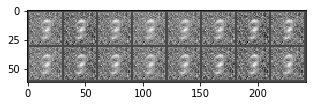

[0/500][200/600][2] Loss_D: -62.198074 Loss_G: -80.494339 Loss_D_real: -144.633774 Loss_D_fake -82.435699


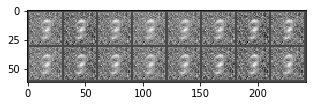

KeyboardInterrupt: 

Process Process-10:
Traceback (most recent call last):
Process Process-9:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Volumes/Transcend/Users/Atom/Documents/Code/Python/VirtualEnv/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Volumes/Transcend/Users/Atom/Documents/Code/Python/VirtualEnv/python3/lib/python3.6/s

In [18]:
from IPython.core.debugger import Tracer
gen_iterations = 0
for epoch in range(niter):
    #Tracer()()
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = 100
        #else:
        #    Diters = opt.Diters
        j = 0
        while j < Diters and i < len(dataloader):
            j += 1

            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)

            data = data_iter.next()
            i += 1

            # train with real
            real_cpu, _ = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)

            if torch.cuda.is_available():
                real_cpu = real_cpu.cuda()
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
            errD_real = netD(inputv)
            errD_real.backward(one)

            # train with fake
            noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            fake = Variable(netG(noisev).data)
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1


        if gen_iterations % 1 == 0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            real_cpu = real_cpu.mul(0.5).add(0.5)
            vutils.save_image(real_cpu, '{0}/real_samples.png'.format(experiment))
            fake = netG(Variable(fixed_noise, volatile=True))
            fake = fake.mul(0.5).add(0.5)
            vutils.save_image(fake.data, '{0}/fake_samples.png'.format(experiment))
            #print('show')
            if torch.cuda.is_available():
                dd = utils.make_grid(fake.cpu().data[:16])
            else:
                dd = utils.make_grid(fake.data[:16])
            dd = dd - dd.min()
            imshow(dd)
            
    # do checkpointing
    #torch.save(netG.state_dict(), '{0}/WGANnetG_epoch_{1}.pth'.format(experiment, epoch))
    #torch.save(netD.state_dict(), '{0}/WGANnetD_epoch_{1}.pth'.format(experiment, epoch))
    torch.save(netG.state_dict(), '{0}/WGANnetG.pth'.format(experiment))
    torch.save(netD.state_dict(), '{0}/WGANnetD.pth'.format(experiment))